### Contents:
+ [1. Import Libraries](#1.-Import-Libraries)
+ [2. Data Collection](#2.-Data-Collection)
    - [2.2 Create Dataframe for data collected](#2.2-Create-Dataframe-for-data-collected)
    - [2.3 Save data to csv file](#2.3-Savedata-to-csv-file)
+ [3. Data Cleaning and EDA](#3.-Data-Cleaning-and-EDA)
    - [3.1 Check for duplicates](#3.1-Check-for-duplicates)
    - [3.2 Look for Outliers](#3.2-Look-for-Outliers)
    - [3.3 Train/Test Split](#3.3-Train-Test-Split)
    - [3.4 Explore stemmer](#3.4-Explore-stemmer)
    - [3.5 Explore Lemmatization](#3.5-Explore-Lemmatization)
    - [3.6 Cleaning the Data](#3.6-Cleaning-the-Data)
    - [3.7 Check for unbalanced classes](#3.7-Check-for-unbalanced-classes)
    - [3.8 Check for null values](#3.8-Check-for-null-values)
    - [3.9 Checkout the most common words](#3.9-Checkout-the-most-common-words)
    - [3.10 Determine if problem can be answered with data collected](#3.10-Determine-if-problem-can-be-answered-with-data-collected)
    - [3.11 Preliminary Evaluation of models for classification problem](#3.11-Preliminary-Evaluation-of-models-for-classification-problem)
    - [3.12 Store the variables for Modeling Notebook](#3.12-Store-the-variables-for-Modeling-Notebook)

# 1. Import Libraries

In [13]:
# Import packages.
import pandas as pd
import numpy as np
import datetime
import time
import requests
import json
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from bs4 import BeautifulSoup
import regex as re
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import unidecode


# 2. Data collection

## 2.1 Get data from Reddit

I will be using Reddit's API to collect data from the following 2 subreddits:<br />
- https://www.reddit.com/r/androidquestions/.json
- https://www.reddit.com/r/iphonehelp/.json

The codes in the cell below will loop 40 times for each subreddit, each round it will collect 25 posts, so I will be getting around 1000 for each subreddit. In total I will have around 2000 observations.

In [ ]:
# Define the user-agent 
headers = {'User-agent': 'E Bot 1.0'}

# setting after = None so I can start from the first page
after = None

# initializing an empty list of posts
android = []
iphone = []

# assigning the url
url_an = "https://www.reddit.com/r/androidquestions/.json"
url_ip = "https://www.reddit.com/r/iphonehelp/.json"

# Each request is 25 posts, and there is a limit of 1000 posts per API call per subeddit, so I will fetch 40x25=1000 
for i in range(40):
    
    # parameters are null for the first page
    if after == None:
        params = {}    
    else:
        # otherwise I have to change the parameter 'after' so it does not start all over again
        params = {'after': after}
        
    # generating the request for Android
    res = requests.get(url_an, params = params, headers = headers)
    
    # if there are no errors
    if res.status_code == 200:
        
        # get the json file
        android_json = res.json()
        
        # extend the list of posts with the children dictionary
        android.extend(android_json['data']['children'])
        
        # reassign the after parameter so the loop can move to the next set of posts
        after = android_json['data']['after']
    
    # if there is an error, print the type and break the loop
    else:
        print("Android Error : ",res.status_code)
        break
    # 1 seconds break before accessing the server again to prevent overloading Reddit server 
    # This will also avoid being blocked by Reddit  
    time.sleep(1)
        

after = None        

for i in range(40):
        # parameters are null for the first page of iphone
    if after == None:
        params = {}    
    else:
        # otherwise I have to change the parameter 'after' so it does not start all over again
        params = {'after': after}
        
    # generating the request for iphone
    res = requests.get(url_ip, params = params, headers = headers)
    
    # if there are no errors
    if res.status_code == 200:
        
        # get the json file
        iphone_json = res.json()
        
        # extend the list of posts with the children dictionary
        iphone.extend(iphone_json['data']['children'])
        
        # reassign the after parameter so the loop can move to the next set of posts
        after = iphone_json['data']['after']
    
    # if there is an error, print the type and break the loop
    else:
        print("iPhone error: ",res.status_code)
        break
        
    # 1 seconds break before accessing the server again to prevent overloading Reddit server 
    # This will also avoid being blocked by Reddit 
    time.sleep(1)

## 2.2 Create Dataframe for data collected

The codes below will combine title and selftext of each post into a singel column, which will become the features/predictors after cleaning, tokenized and counted.
The rest of the data (e.g. url, author) are not used at moment. They are extracted and stored in case I need them later.

In [3]:

# I skip first 2 rows of each subreddi because they are instructions from the subreddit admin


android_id = []
android_text = []
android_author = []
android_url = []
android_com = []
android_utc = []
android_epoch = []
android_ups = []
android_downs = []
android_view = []
android_gilded = []
android_score = []

iphone_id = []
iphone_text = []
iphone_author = []
iphone_url = []
iphone_com = []
iphone_utc = []
iphone_epoch = []
iphone_ups = []
iphone_downs = []
iphone_view = []
iphone_gilded = []
iphone_score = []

for i in range(2, len(android)):
    
    
    # combine title and selftext to form the text list
    android_text.append(android[i]['data']['title'] + ' ' + android[i]['data']['selftext'])

    # get post's id
    android_id.append(android[i]['data']['id'])

    # get post's up vote
    android_ups.append(android[i]['data']['ups'])
    
    # get post's down vote
    android_downs.append(android[i]['data']['downs'])
    
    # get post's number of views
    android_view.append(android[i]['data']['view_count'])
    
    # get post's guilded
    android_gilded.append(android[i]['data']['gilded'])
    
    # get post's score
    android_score.append(android[i]['data']['score'])

    # get post's author
    android_author.append(android[i]['data']['author'])

    # get post's url
    android_url.append(android[i]['data']['url'])

    # get post's number of comments
    android_com.append(android[i]['data']['num_comments'])

    # get post's UTC time in epoch format
    android_epoch.append(android[i]['data']['created_utc'])
    
    # get post's creation time in epoch time and convert to UTC date/time 
    android_utc.append(datetime.datetime.fromtimestamp(android[i]['data']['created_utc']).strftime('%Y-%m-%d %H:%M:%S'))

    
for i in range(0, (len(iphone))):
    
    # combine title and selftext to form the text list
    iphone_text.append(iphone[i]['data']['title'] + ' ' + iphone[i]['data']['selftext']) 

    # get post's id
    iphone_id.append(iphone[i]['data']['id'])

    # get post's up vote
    iphone_ups.append(iphone[i]['data']['ups'])
    
    # get post's down vote
    iphone_downs.append(iphone[i]['data']['downs'])
    
    # get post's view count
    iphone_view.append(iphone[i]['data']['view_count'])
    
    # get post's gilded
    iphone_gilded.append(iphone[i]['data']['gilded'])
    
    
    # get post's score
    iphone_score.append(iphone[i]['data']['score'])
    
    
    # get post's author
    iphone_author.append(iphone[i]['data']['author'])

    # get post's url
    iphone_url.append(iphone[i]['data']['url'])

    # get post's number of comments
    iphone_com.append(iphone[i]['data']['num_comments'])

    
    # get post's UTC time in epoch format
    iphone_epoch.append(iphone[i]['data']['created_utc'])
    
    # get post's creation time in epoch time and convert to UTC date/time 
    iphone_utc.append(datetime.datetime.fromtimestamp(iphone[i]['data']['created_utc']).strftime('%Y-%m-%d %H:%M:%S'))
    

# create dataframes for android and iphone subreddit
android_df = pd.DataFrame(android_id, columns=['post_id'])
iphone_df = pd.DataFrame(iphone_id, columns=['post_id']) 
    
# add post text to dataframes
android_df['post'] = android_text
iphone_df['post'] = iphone_text

# add post up votes to dataframes
android_df['ups'] = android_ups
iphone_df['ups'] = iphone_ups

# add post down votes to dataframes
android_df['downs'] = android_downs
iphone_df['downs'] = iphone_downs

# add post view count to dataframes
android_df['view_count'] = android_view
iphone_df['view_count'] = iphone_view

# add post gilded to dataframes
android_df['gilded'] = android_gilded
iphone_df['gilded'] = iphone_gilded

# add post score to dataframes
android_df['score'] = android_score
iphone_df['score'] = iphone_score

# add post author to dataframes
android_df['author'] = android_author
iphone_df['author'] = iphone_author

# add post url to dataframes
android_df['url'] = android_url
iphone_df['url'] = iphone_url

# add number of comments to dataframes
android_df['num_comments'] = android_com
iphone_df['num_comments'] = iphone_com

# add UTC timestamp of post creation to dataframes
android_df['created_utc'] = android_utc
iphone_df['created_utc'] = iphone_utc

# add post UTC time in epoch format to dataframes
android_df['utc_epoch'] = android_epoch
iphone_df['utc_epoch'] = iphone_epoch

# adding a column to classify the subreddits, android = 1, iphone = 0
android_df['subreddit'] = 1
iphone_df['subreddit'] = 0

# combine the 2 dataframes
phone_df = pd.concat([android_df,iphone_df],ignore_index=True)

# checking
phone_df.head()

,post_id,post,ups,downs,view_count,gilded,score,author,url,num_comments,created_utc,utc_epoch,subreddit
0,hfr5q6,Strange giggling sound coming from Galaxy S10+...,27,0,None,0,27,weirdlaughingsound,https://www.reddit.com/r/AndroidQuestions/comm...,24,2020-06-26 02:18:13,1.593109e+09,1
1,hfkkil,My phone only charges from a laptop and not th...,31,0,None,0,31,AndreewPFG123,https://www.reddit.com/r/AndroidQuestions/comm...,16,2020-06-25 19:37:20,1.593085e+09,1
2,hfwhpy,Images sent over Google Messages aren't delive...,2,0,None,0,2,sadboi2021,https://www.reddit.com/r/AndroidQuestions/comm...,4,2020-06-26 07:19:54,1.593127e+09,1
3,hfulkq,Difference between the versions of firefox So ...,2,0,None,0,2,sa09-fask0-,https://www.reddit.com/r/AndroidQuestions/comm...,2,2020-06-26 05:29:38,1.593121e+09,1
4,hfxrrp,Hole in phone speaker So I had some dust/dirt ...,1,0,None,0,1,M88nlite,https://www.reddit.com/r/AndroidQuestions/comm...,0,2020-06-26 08:42:11,1.593132e+09,1


In [4]:
phone_df.tail()

,post_id,post,ups,downs,view_count,gilded,score,author,url,num_comments,created_utc,utc_epoch,subreddit
1982,hf9fqg,My company now offers smartphones for employee...,2,0,None,0,2,tigerx95,https://www.reddit.com/r/iphonehelp/comments/h...,5,2020-06-25 05:03:20,1.593033e+09,0
1983,hfcu24,Uploading only select folders from the Photos ...,1,0,None,0,1,win_linx,https://www.reddit.com/r/iphonehelp/comments/h...,0,2020-06-25 08:46:33,1.593046e+09,0
1984,hfcbn5,Dropped iPhone X in water? My phone fell in wa...,1,0,None,0,1,Punsnotbuns,https://www.reddit.com/r/iphonehelp/comments/h...,2,2020-06-25 08:05:26,1.593044e+09,0
1985,hfbcxp,Maybe: ...I don’t want Siri to advertise me to...,0,0,None,0,0,RavenIl,https://www.reddit.com/r/iphonehelp/comments/h...,4,2020-06-25 06:52:51,1.593039e+09,0
1986,hfb2mm,Restore / back up someone else’s iPhone Hey gu...,1,0,None,0,1,Fwxo,https://www.reddit.com/r/iphonehelp/comments/h...,2,2020-06-25 06:35:16,1.593038e+09,0


## 2.3 Save data to csv file

In [5]:
# generate a filename based on current year, month, day, hour, minute and second
d=datetime.datetime.now()
path = '../datasets/all_phones_'+str(d.year)+str(d.month)+str(d.day)+str(d.hour)+str(d.minute)+str(d.second)+'.csv'

phone_df.to_csv(path, index = False)

## 2.4 Read data from csv file

In [46]:
phone_df = pd.read_csv('../datasets/all_phones_202062685831.csv')

In [47]:
len(phone_df)

1987

# 3. Data Cleaning and EDA

## 3.1 Check for duplicates

In [48]:
# check for duplicates
phone_df[phone_df.duplicated(['post_id'])==True]

,post_id,post,ups,downs,view_count,gilded,score,author,url,num_comments,created_utc,utc_epoch,subreddit
1961,fvvcwj,"Asking Questions 101: How To Ask People For Help? There are a lot of posts on this sub with vague questions, vague symptoms, a lot of missing information and bad-explained overall. I wanted to show you how to ask a good question, from an ex-Apple iOS technician.\n\nHere's how to ask a good question:\n\n**1. iPhone model and iOS version**\n\n*e.g. iPhone XS running iOS 13.2*\n\n**2. Purchase date, country and nature of purchase**\n\nPeople who answer your issue can suggest certain repairs, e.g. warranty. Country and nature of purchase also helps, since countries have different consumer protection laws. For instance, members of the European Union have a two year warranty at the point of purchase (i.e. that might not be Apple, but your local electronics store if you bought it there) - some countries (e.g. the U.K. and The Netherlands) have even longer periods consumers can claim warranty. \n\n*e.g. March 20th, 2019 in the Apple Store in the U.K., purchase for personal use*\n\n**3. What is the issue, how often does it occur and how to replicate it?**\n\nSome issues are continuous, some are intermittent. It is important to let people know what the issue is and how often it occurs. ""iPhone restarts"" as issue, is not enough.\n\n*e.g. iPhone crashes to springboard when opening the camera-app, this happens about three times a day at random moments. It only happens when opening the camera-app.*\n\n**4. What caused the issue?**\n\nThere's not always a clear cause, but think about anything that could've caused it. It could be because your phone was in your pocket during heavy rain, or your cat knocked it from your desk. It could be anything.\n\n**5. What did you try to resolve the issue and what was the result?**\n\nSo people don't waste time answering possibilities you already tried\n\n*e.g. I tried to force-close the camera app. This did not work. Then I tried to restart the phone, that also did not work.*\n\n**6. Any other information you think might be useful.**\n\nAdd photos or other comments\n\n\------------\n\nIf you want the best help, make sure to include these steps into your topic - this community is happy to help, but try to be as precise as possible. Even information you think is insignificant might help!",35,0,NaN,1,35,The-Hyrax,https://www.reddit.com/r/iphonehelp/comments/fvvcwj/asking_questions_101_how_to_ask_people_for_help/,5,2020-04-06 16:57:37,1.586163e+09,0
1962,hfsh48,"My iPhone Face ID doesn’t work. It says iPhone needs to cool down before using Face ID despite my iPhone not being hot. \nSo it said iPhone needs to cool down before using Face ID. So I tried to reset it, and now it is saying, iPhone needs to cool down before setting up Face ID. My iPhone is not hot however. \n\nAlso alongside this problem, I think they must be connected as they both started together and at the same time, my iPhone has also started draining as well. Just on standby it can go from 100% to 0% in 6-7 hours. And that’s on standby. Not while using.\n\nI thought maybe it was a software problem and updated it to the latest iOS and still the same. \n\nI’ve deleted any apps I think that might be it and gone in settings to check what it may be and etc etc. \n\nCan anyone help?",4,0,NaN,0,4,Heema123789,https://www.reddit.com/r/iphonehelp/comments/hfsh48/my_iphone_face_id_doesnt_work_it_says_iphone/,8,2020-06-26 03:31:11,1.593113e+09,0
1963,hfxewd,"iPhone 8 is not receiving text notifications from a specific contact I’m truly not sure how this is happening. I get text notifications from all of my other contacts just fine, and I even get the notifications from this specific contact on my iPad, but not my iPhone. The contact is not on Do Not Disturb, and I’ve tried turning it off and on to no avail. If anyone could point me in the right direction that’d be greatly appreciated.",1,0,NaN,0,1,SeargantSarcasm,https://www.reddit.com/r/ip

In [49]:
# drop duplicates if necessary
phone_df.drop_duplicates(['post_id'],inplace=True)

## 3.2 Look for Outliers 
Contextual outliers are observations that are out of context for the project. Since I am interested in only Android and iPhone related posts, I will consider those for other mobile operating systems to be contextual outliers.

There are many other mobile operating systems that make up a very small percentage of the phone market.

In [50]:
# Set to no display restriction to allow viewing of entire messages
pd.set_option('display.max_colwidth',None)

# Commonly found mobile operating systems that are not Android or iphone
word = "kaios|symbian|tizen|sailfish|webos|bada|cyanogen|meego|liteos|kindle"

# check through the dataframe for posts not related to Android or iphone
phone_df[phone_df['post'].str.contains(word,case=False)].loc[:,'post']

536                                                                                                                                                                                                                         What text to voice application do you recommend? Hi,\n\nI own an amazon kindle device. I used to read books on it almost every day until recently I discovered the comfort and power of an audiobook. I am so hooked to the idea of an audiobook as I could listen to it while in bed at night without stressing my eyes.\n\nI am on a budget and not sure if going with an on-demand service like audible will fit me in the long run. I find it quite good but a bit overpriced IMO. So, I thought using a text to speech application (Android-based) would be a good idea.\n\nWhat mobile application for text to speech conversion would you recommend? Features I am looking for: voice to feel more natural, option to bookmark, simple. It would be nice if the app is FOSS. Thanks.
576    Trying to

In [10]:
len(phone_df)

1958

In [51]:
# Posts have been verified to be not related to Android or iPhone, so they will be removed

phone_df.drop(index=188,inplace=True)
phone_df.drop(index=228,inplace=True)
phone_df.drop(index=374,inplace=True)
phone_df.drop(index=623,inplace=True)


# Reset dataframe index
phone_df.reset_index(drop=True)

,post_id,post,ups,downs,view_count,gilded,score,author,url,num_comments,created_utc,utc_epoch,subreddit
0,hfr5q6,"Strange giggling sound coming from Galaxy S10+ Like the topic says, I've heard a faint giggling sound coming from my S10+ a couple times today. It happened once while I was briefly on the Tumblr app and again I believe while I was on Chrome. There was no indication from the notification bar indicating which app it could have potentially come from and it only lasted a second or two, so I didn't have the time to screen record it.\n\nI tried researching the potential cause of this and found a small handful of similar posts from the past decade but no real diagnosis of the problem or solution to it. I don't do any shady browsing on my phone and the only apps I have that didn't come from the Play Store are Tachiyomi and Blokada. I've run scans from both Avast and Malwarebytes and neither have found anything.\n\nWhat should I do? Do I just need to do a factory reset or can that be avoided? If I have to reset the phone, do I have to leave behind all the files and images currently on it?",27,0,NaN,0,27,weirdlaughingsound,https://www.reddit.com/r/AndroidQuestions/comments/hfr5q6/strange_giggling_sound_coming_from_galaxy_s10/,24,2020-06-26 02:18:13,1.593109e+09,1
1,hfkkil,"My phone only charges from a laptop and not the outlet I have a Samsung Galaxy A50 and this started to happen yesterday. \n\nI have tried cleaning the charger and the phone's port with no succes, also changing the charger, but it still would only charge from the laptop.\n\nThere isn't anything visibily wrong with the port or any of the chargers. \n\nI did charge my phone on an outlet that is a bit broken and it might have accidently given it too much power and fried the charging port... so maybe that's the reason but I don't really think so since it still charges from the laptop\n\nEdit: I am pretty sure it is the adapter\n\nI thank you all for helping me, I don't think I would have figured it out on my own and would have probably sent it back.",31,0,NaN,0,31,AndreewPFG123,https://www.reddit.com/r/AndroidQuestions/comments/hfkkil/my_phone_only_charges_from_a_laptop_and_not_the/,16,2020-06-25 19:37:20,1.593085e+09,1
2,hfwhpy,"Images sent over Google Messages aren't delivering, get stuck on ""Sent"" Chat features are enabled on both ends. Pretty sure the recipient hasn't blocked me. Under the ""Resend message if undelivered"" setting, I've selected ""Ask before resending,"" but I haven't been asked anything. In the past I tried putting the device into airplane mode and resending, but the image still didn't deliver. Haven't tried it again because I don't want to risk inadvertently spamming this person with images.\n\n&amp;#x200B;\n\nEdit: My device is an AT&amp;T Galaxy S7 Edge, if it matters",2,0,NaN,0,2,sadboi2021,https://www.reddit.com/r/AndroidQuestions/comments/hfwhpy/images_sent_over_google_messages_arent_delivering/,4,2020-06-26 07:19:54,1.593127e+09,1
3,hfulkq,"Difference between the versions of firefox So I think I understand preview/nightly/focus, but I see two seperate listings in the play store for what looks like just the base browser - one called ""Firefox Browser"" and one called ""Mozilla Firefox Browser"", with different amounts of downloads, different ratings, and so on. Why is this, and does it matter which one I download?",2,0,NaN,0,2,sa09-fask0-,https://www.reddit.com/r/AndroidQuestions/comments/hfulkq/difference_between_the_versions_of_firefox/,2,2020-06-26 05:29:38,1.593121e+09,1
4,hfxrrp,"Hole in phone speaker So I had some dust/dirt in my phone speaker and in order to clean it i used an embroidery needle (I know, not a smart idea) I got everything out but in the process i must have punctured a small hole in said speaker, now causing the audio to be atrocious, it has a horrible echo and listening to anything on it is giving me horrible headaches. \n\nDoes anyone know if there's a way I can fix this? Or at least make it more tolerable. 

## 3.3 Train Test Split

In [52]:
# defining X and y
X = phone_df['post']
y = phone_df['subreddit']

# 80/20 train/test split
# stratify=y will ensure that I have the same proportion of classes in training and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=42)

## 3.4 Explore stemmer

Try out porter stemmer on one of the posts

In [53]:
# choose a suitable post for testing stemmer and lemmatization
phone_df['post'][120]

'Galaxy S20 ultra Long story short, daughter tried to unlock phone while I was asleep, it went into factory reset. Any software or anything i can do to recover the pics I had with her? Seen sketchy reviews for Dr.fone so would rather stay away from that. I use the photo app that comes with the phone. Should be samsung but unsure'

In [54]:
# Instantiate stemmer.
from nltk.stem.porter import PorterStemmer

# Instantiate object of class PorterStemmer.
p_stemmer = PorterStemmer()

# Use one of the posts for testing
key_words = phone_df['post'][120].lower().split()

# Stem tokens.
stem_words = [p_stemmer.stem(i) for i in key_words]

# Print only those stemmed tokens that are different.
for i in range(len(key_words)):
    if key_words[i] != stem_words[i]:
        print((key_words[i], stem_words[i]))

('galaxy', 'galaxi')
('story', 'stori')
('tried', 'tri')
('was', 'wa')
('factory', 'factori')
('any', 'ani')
('software', 'softwar')
('anything', 'anyth')
('recover', 'recov')
('pics', 'pic')
('sketchy', 'sketchi')
('reviews', 'review')
('comes', 'come')
('unsure', 'unsur')


#### Stemming managed to reduce inflection in many words but it also change the meaning of some of them, which will result in lower precision.

## 3.5 Explore Lemmatization

In [55]:
# Function to implment POS (Part of Speech) Tagger that tags part of speeach as adjective, noun, verb or adverb
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [56]:
# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Use one of the posts for testing
key_words = phone_df['post'][120].lower().split()

# Lemmatize tokens.
tokens_lem = [lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in key_words]

# Print only those lemmatized tokens that are different.
for i in range(len(key_words)):
    if key_words[i] != tokens_lem[i]:
        print((key_words[i], tokens_lem[i]))

('tried', 'try')
('was', 'be')
('went', 'go')
('pics', 'pic')
('had', 'have')
('seen', 'see')
('reviews', 'review')
('comes', 'come')


##### Lemmatization with Pos tag successfully converted words in past tense into present tense (e.g. wanted to want) and words in continuous tense to present tense (e.g. looking to look), plural to singular (e.g. texts to text), so it  is the better way of grouping the different inflected forms of a word than stemming, from a grammatical/morphological point of view. 
##### I will only be using lemmatization for cleaning the text data. Stemming will not be used.

## 3.6 Cleaning the Data

In [73]:
# This function will clean the data and return as a string
# 1. Remove HTML tags
# 2. Remove unnecessary words url strings in the message
# 3. Remove words that are causing high correlations
# 4. Remove non-printable unicode characters
# 5. Remove accented words
# 6. Remove special characters. Keep letters.
# 7. Remove single characters between words
# 5. Remove extra whitespaces
# 6. Convert to lower case, split into individual words
# 7. Remove stopwords
# 8. Lemmatization


def post_to_words(raw):
   # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    
    # Remove HTML tags
    post_text = BeautifulSoup(raw).get_text()
      
    # Remove unnecessary characters from url, such as http, www, com, com.sg
    post_text = re.sub(r"[.][cC][oO][mM][.]?[A-Za-z]?[A-Za-z]?"," ",post_text)
    post_text = re.sub(r"[hH][tT][tT][pP][sS]?:\/\/[wW]?[wW]?[wW]?.?"," ",post_text)
    post_text = re.sub(r"[wW][wW][wW]."," ",post_text)
    

    # Remove words that cause high correlation problem among independent variables
    post_text = post_text.replace('reddit',' ').replace('able',' ').replace('access',' ')
    post_text = post_text.replace('add',' ').replace('advance',' ')
    
    # Remove non-printable unicode characters
    post_text = post_text.replace('x200B',' ').replace('\n',' ')
    
    # remove accented words such as latté and café to avoid being treated as separate words
    post_text = unidecode.unidecode(post_text)
    
    
    # Remove non-letters.
    post_text = re.sub("[^a-zA-Z]", " ", post_text)

    # Remove single characters between words
    post_text = re.sub("\s+[a-zA-Z]\s+"," ", post_text)
    
    # Remove single characters at the beginning of a post
    post_text = re.sub("\^[a-zA-Z]\s+"," ", post_text)
    
    # Many cleaning steps replace unwanted characters with spaces, so many would be left behind
    # Reduce multiple spaces into one
    post_text = re.sub("\s+"," ", post_text)
    
    # Convert to lower case, split into individual words.
    post_text = post_text.lower().split()
    
    # In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set before using them to remove words from original text 
    post_text = [w for w in post_text if not w in set(stopwords.words('english'))]
    
    # Lemmatize tokens
    # Setup preserved_words list to skip important words
    # e.g. ios (ipone OS) was found to be lemmatized to "io" and Logistic Regression 
    # gives the word
    preserved_words = ['ios']   
    tokens_lem=[]
    for i in post_text:
        if i in preserved_words:
            tokens_lem.append(i)
        else:
            tokens_lem.append(lemmatizer.lemmatize(i,get_wordnet_pos(i))) 
        
    
    # Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(tokens_lem))

In [74]:
# Get the number of posts based on the dataframe size.
total_posts = phone_df.shape[0]
print(f'There are {total_posts} posts.')

# Initialize an empty list to hold the cleaned posts
clean_train_posts = []
clean_test_posts = []

There are 1957 posts.


In [75]:
print("Cleaning and parsing the reddit posts...")

for p in X_train:
    # Convert posts to words, then append to clean_train_posts.
    clean_train_posts.append(post_to_words(p))


for p in X_test:
    # Convert posts to words, then append to clean_test_posts.
    clean_test_posts.append(post_to_words(p))
    
    
print('Cleaning completed')

Cleaning and parsing the reddit posts...
Cleaning completed


In [78]:
# Create a basic CountVectorizer with top 100 features and a dataframe to explore the data

cvec_1 = CountVectorizer(max_features=100)

X_train_cvec_1 = cvec_1.fit_transform(clean_train_posts)
X_test_cvec_1 = cvec_1.fit_transform(clean_test_posts)

X_train_df_1 = pd.DataFrame(X_train_cvec_1.todense(),
                          columns = cvec_1.get_feature_names())

## 3.7 Check for unbalanced classes

In [80]:
# For classification problem we need to check for unbalanced classes

phone_df['subreddit'].value_counts()

1    991
0    966
Name: subreddit, dtype: int64

In [81]:
y_train.T.value_counts()

1    792
0    773
Name: subreddit, dtype: int64

In [82]:
y_test.T.value_counts()

1    199
0    193
Name: subreddit, dtype: int64

|Dataset|Count of Android posts|Count of iPhone posts|Ratio of Android to iPhone posts|
|---|---|---|---|
|Training|792|773|0.506|
|Testing|199|193|0.506|

#### The above results show there is no unbalanced class issue, and the ratios between Android and iPhone are the same for Training and Test datasets, due to the setting of stratify parameter during traing_test_split 

## 3.8 Check for null values

In [67]:
# I already know there are 1 and 0 values (2 unique)....the result will show 3 if there is NaN

y_train.nunique(dropna=False)

2

In [68]:
# Do we have any null values in features?
X_train_df_1.isnull().sum().sort_values(ascending=False)

youtube     0
guy         0
galaxy      0
gallery     0
game        0
           ..
recently    0
record      0
recovery    0
remove      0
10          0
Length: 500, dtype: int64

#### No null values found, which is essential for modeling

## 3.9 Checkout the most common words

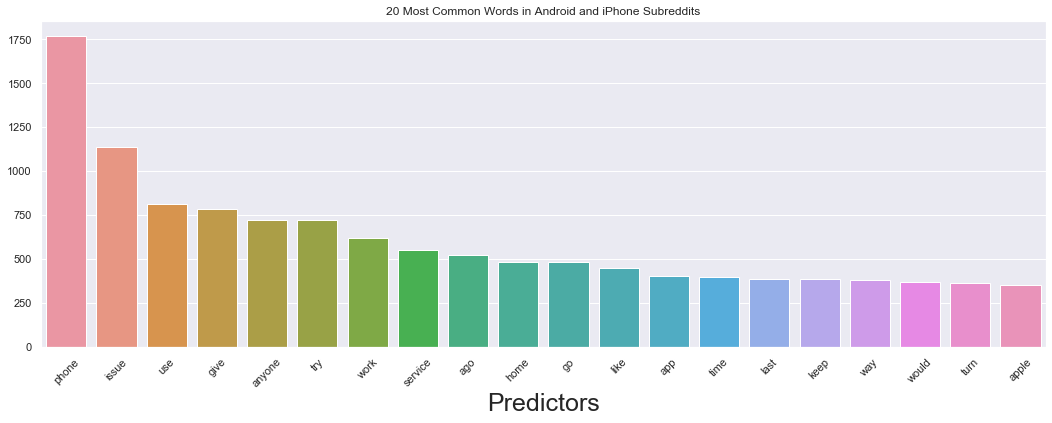

In [96]:
# Retrieve the list of words (vocabulary) and counts created by vectorizer
word_counts = X_train_df_1.sum(axis=0)

# Visualize the Top 20 words with a barplot
fig = plt.figure(figsize=(18,6))
sns.set(font_scale=1)
words=word_counts.sort_values(ascending = False).head(20).index.tolist()
counts=word_counts.sort_values(ascending = False).head(20).tolist()

plt.rcParams.update({'font.size':30})
bar_plot = sns.barplot(x=words, y=counts)
for item in bar_plot.get_xticklabels():
    item.set_rotation(45)
plt.title('20 Most Common Words in Android and iPhone Subreddits')
plt.xlabel('Predictors', fontsize=25)
plt.show()

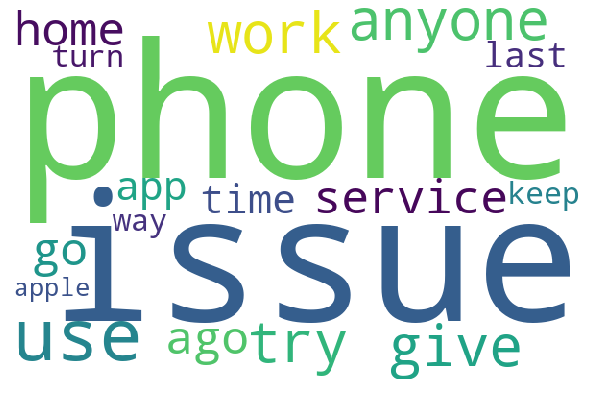

In [95]:
# Visualize Top 20 common words with a wordcloud

common_words = '' 

tokens = word_counts.sort_values(ascending = False).head(20).index.tolist()
      
# Converts each token into lowercase 
for i in range(len(tokens)): 
    tokens[i] = tokens[i].lower()       

common_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 600, height = 400,
                prefer_horizontal=1,
                background_color ='white', 
                min_font_size = 10).generate(common_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

## 3.10 Determine if problem can be answered with data collected

Does the student address whether or not they are likely to be able to answer their problem statement with the provided data given what they've discovered during EDA?

#### Check if the data is suitable for Naive Bayes Bernoulli of Multinomial. The former is for binary values, and the latter is for non-binary numbers 

In [71]:
# The following codes will check how many columns have values of 0 or 1
binary_cols = [col for col in X_train_df_1
             if np.isin(X_train_df_1[col].dropna().unique(), [0, 1]).all()]

print(f"There are {len(binary_cols)} columns with values of 0 or 1, the rest of 500 feature columns are non-binary numbers.")

There are 11 columns with values of 0 or 1, the rest of 500 feature columns are non-binary numbers.


### Find the lowest negative correlation and highest positive correlation between independent variables

In [79]:
# get the pairwise correlation of oll columns in the dataframes
corr = X_train_df_1.corr()

# loop through the dataframe to find the lowest and higher correlation numbers 
# Correlation between the same feature will be Ones, so those will be skipped

maxx=0
minn=0
for i in range(len(corr)):
    for j in range(len(corr)):
        if i != j:
            if corr.iloc[i,j]>0:
                if corr.iloc[i,j]>maxx:
                    maxx=corr.iloc[i,j]
                    if maxx >= 0.9:
                        print("Words that are highly correlated:",corr.index[i],corr.columns[j],maxx)
            else:
                if corr.iloc[i,j]<minn:
                    minn=corr.iloc[i,j]
                
print("Lowest negative correlation between features:",minn)
print("Highest positive correlation between features:",maxx)

Lowest negative correlation between features: -0.12226612518229948
Highest positive correlation between features: 0.4090848528532224


### Solving Classification Problem

- The dependent variable or Outcome is either Android or iPhone, so it is a classification problem
- No unbalance class issue (ratio is 0.506 for both training and test datasets)
- The independent variables are numbers (they will be once vectorized into word counts or tf-idf)
- No high correlations among the the independent variables (less than 0.9)
- Independent variables are independence from one another (highest correlation is less than 0.9)
- For Naive Bayes classifier I will be using multinomial as the data is not binary


[[Reference:](https://www.statisticssolutions.com/what-is-logistic-regression/)]

## 3.11 Preliminary Evaluation of models for classification problem
Naive Bayes, KNN and Logistic Regression will be evaluated.

In [85]:
# Instantiate classifiers for evaluation

logreg_class = LogisticRegression()
logreg_class.fit(X_train_cvec_1, y_train)

knn_class = KNeighborsClassifier()
knn_class.fit(X_train_cvec_1, y_train)

naivebayes_class = MultinomialNB()
naivebayes_class.fit(X_train_cvec_1, y_train);

In [90]:
def accuracy_scorer(model, X_train, X_test, y_train, y_test):
    accuracy_train = accuracy_score(y_true = y_train,
                        y_pred = model.predict(X_train))
    accuracy_test = accuracy_score(y_true = y_test,
                       y_pred = model.predict(X_test))
    
    print("The training accuracy for " + str(model) + " is: " + str(accuracy_train))
    print("The testing accuracy for " + str(model) + " is: " + str(accuracy_test))
    return (accuracy_train, accuracy_test)


In [89]:
print(accuracy_scorer(logreg_class, X_train_cvec_1, X_test_cvec_1, y_train, y_test))
print()
print(accuracy_scorer(knn_class, X_train_cvec_1, X_test_cvec_1, y_train, y_test))
print()
print(accuracy_scorer(naivebayes_class, X_train_cvec_1, X_test_cvec_1, y_train, y_test))

The training accuracy-score for LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) is: 0.9233226837060703
The testing accuracy-score for LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) is: 0.6836734693877551
(0.9233226837060703, 0.6836734693877551)

The training accuracy-score for KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                  

<h4 align=center> Summary Table of training and testing Accuracy Score</h4>

|           Model          | Training Accuracy | Testing Accuracy |
|:------------------------:|:----------------:|:----------------:|
|     Logistic Regression  |   0.923          |     0.683        |
|    k-Nearest Neighbors   |   0.858          |     0.632        |
| Naive Bayes Mulitnomial  |   0.900          |     0.633        |


#### KNN has the lowest scores for accuracy, for both Training and Test datasets. Since I am only choosing 2 models for detailed analysis, I will drop KNN and focus the othe two classifiers.

## 3.12 Store the variables for Modeling Notebook

In [91]:
%store y_train

%store y_test
%store clean_train_posts
%store clean_test_posts

Stored 'y_train' (Series)
Stored 'y_test' (Series)
Stored 'clean_train_posts' (list)
Stored 'clean_test_posts' (list)


In [92]:
%store

Stored variables and their in-db values:
clean_test_posts              -> ['possible set hourly notification limit apps andr
clean_train_posts             -> ['way force battery charge rather phone decide use
y_test                        -> 561     1
809     1
330     1
1541    0
46      1

y_train                       -> 1457    0
1745    0
1313    0
1894    0
76      1

